<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/YOLO_v1_self_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building YOLO v1
I am studying PyTorch and Computer Vision. I know how to make CNN, TinyVGG. I have some convidence to make other Computer Vision model and I started with YOLO v1. YOLO, which stands for *You Only Look Once* is a fast model but, heavy to run on colab. So, I decided to make one by myself using the following Image!



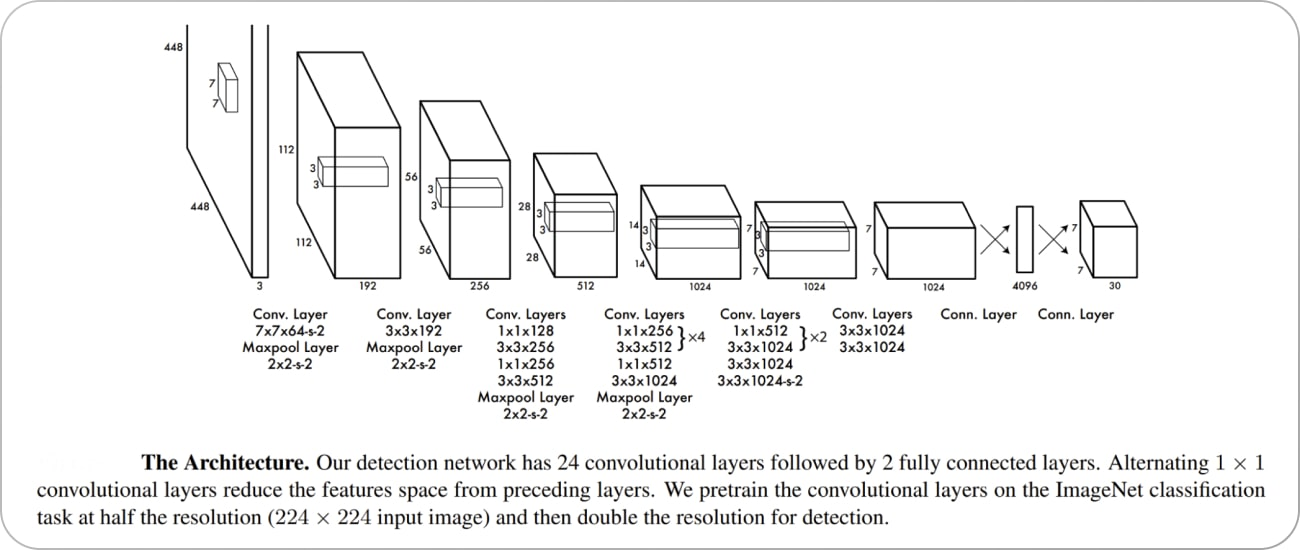


### 1. Setting up the basics
I've used data of *Pizza-Steak-Sushi* from mrdbourke. Data is at following url : https://github.com/mrdbourke/pytorch-deep-learning/tree/main/data

* 225 training sets
* 75 test sets

In [ ]:
import torch
import torch.nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)

2.4.1+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} director yalready exists... skipping download")
else:
  print(f"{image_path} doesn't exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  # the file needs to be raw not blob
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, suchi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating one...
Unzipping pizza, steak and sushi data...


In [ ]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its conents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)


There are 2 directoreis and 0 images in 'data/pizza_steak_sushi'.
There are 3 directoreis and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directoreis and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directoreis and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directoreis and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directoreis and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directoreis and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directoreis and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directoreis and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/sushi/3360232.jpg
Image class: sushi
Image height: 384
iamge width : 512


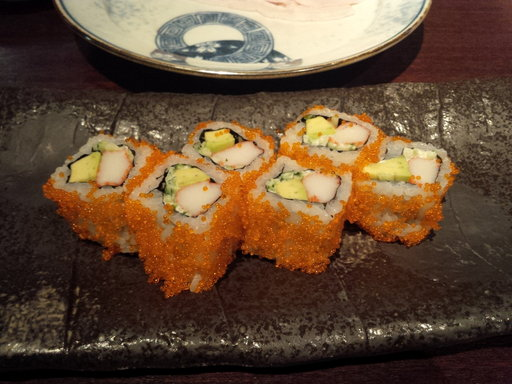

In [ ]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths()
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the iamge is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"iamge width : {img.width}")
img

In [ ]:
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper function.py already exiss")
else:
  print("Downloading helper function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

(-0.5, 511.5, 383.5, -0.5)

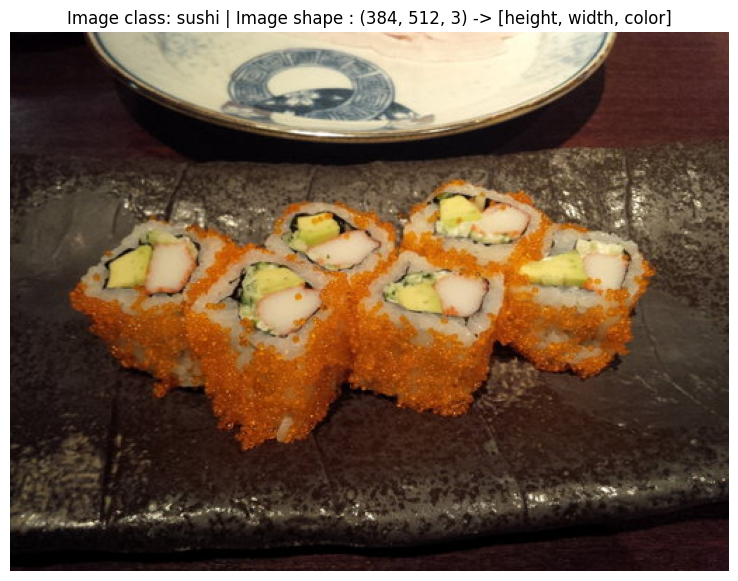

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape : {img_as_array.shape} -> [height, width, color]")
plt.axis(False)

## 2. Making input image match
YOLO accepts 448 * 448 image files for the input so, I have to transform the image size.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 448 * 448
    transforms.Resize(size=(448, 448)),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

data_transform(img)

tensor([[[0.0314, 0.0314, 0.0314,  ..., 0.3843, 0.3961, 0.4196],
         [0.0157, 0.0157, 0.0157,  ..., 0.3804, 0.3882, 0.4118],
         [0.0157, 0.0118, 0.0118,  ..., 0.3843, 0.3882, 0.4078],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.1490, 0.1412, 0.1412],
         [0.0784, 0.0824, 0.0863,  ..., 0.1451, 0.1490, 0.1569],
         [0.0667, 0.0706, 0.0784,  ..., 0.1529, 0.1608, 0.1725]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.2235, 0.2353, 0.2588],
         [0.0078, 0.0078, 0.0078,  ..., 0.2196, 0.2275, 0.2510],
         [0.0078, 0.0039, 0.0039,  ..., 0.2235, 0.2275, 0.2471],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0392, 0.0431,  ..., 0.0627, 0.0667, 0.0745],
         [0.0196, 0.0235, 0.0314,  ..., 0.0706, 0.0784, 0.0902]],

        [[0.0353, 0.0353, 0.0353,  ..., 0.2000, 0.2157, 0.2431],
         [0.0196, 0.0196, 0.0196,  ..., 0.1961, 0.2118, 0.2353],
         [0.0196, 0.0157, 0.0157,  ..., 0.2000, 0.2078, 0.

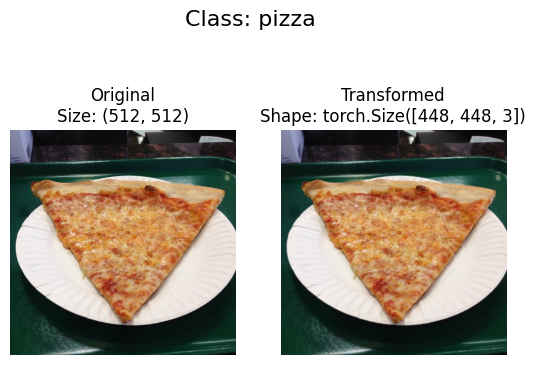

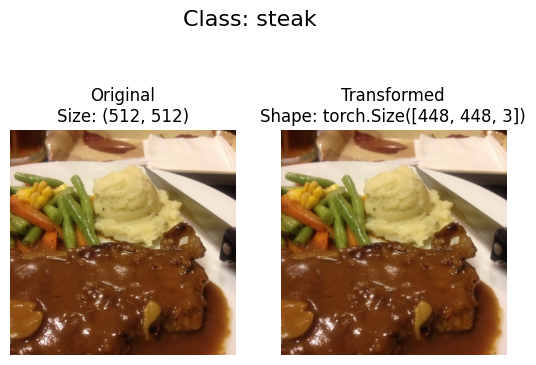

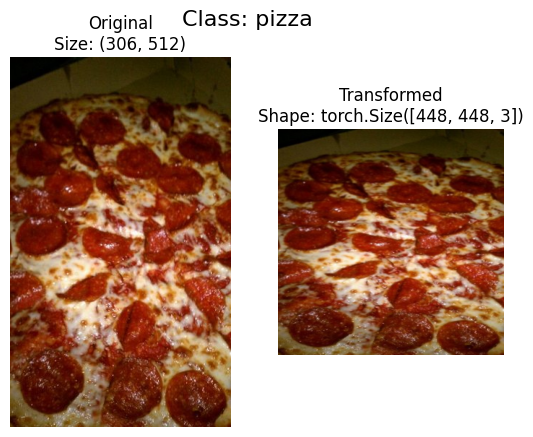

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform an plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

class_names = train_data.classes
train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

# Get class name as dict
class_dict = train_data.class_to_idx
class_dict

# Chcek the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
CPU_COUNT = os.cpu_count()

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = CPU_COUNT,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = CPU_COUNT,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c6cd3bf3430>,
 <torch.utils.data.dataloader.DataLoader at 0x7c6cd3bf3490>)

### 3. Building Model

In [ ]:
from torch import nn
import torch.nn.functional as F

class YOLOV1(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size= 7,stride=2,padding=3),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,out_channels = hidden_units,kernel_size = 3,padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.block_3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,out_channels = 128,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1,),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels = 256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size =2,stride = 2)
    )

    self.block_4 = nn.Sequential(
        nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=512,out_channels=512,kernel_size = 1, padding = 0),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=512,out_channels=1024,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size =2,stride = 2)
    )

    self.block_5 = nn.Sequential(
      nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
      nn.LeakyReLU(),
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
      nn.LeakyReLU(),
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=2),
      nn.LeakyReLU(),
  )
    self.block_6 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=0,),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,),
        nn.LeakyReLU(),
    )

    self.flatten = nn.Flatten()

    self.block_7 = nn.Sequential(
      nn.Linear(in_features=1024 * 5 * 5, out_features=4096),
      nn.LeakyReLU()
    )
    self.block_8 = nn.Sequential(
      nn.Linear(in_features=4096, out_features=output_shape),
    )



  def forward(self, x:torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = self.block_5(x)
    x = self.block_6(x)

    x = self.flatten(x)

    x = self.block_7(x)
    x = self.block_8(x)

    #x = F.softmax(x, dim=1)

    return x



In [ ]:
model_0 = YOLOV1(input_shape=3,
                 hidden_units=64,
                 output_shape=len(class_names)).to(device)
model_0

YOLOV1(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(), lr=0.01)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    # print(f"y_pred : {y_pred}")
    # print(f"y : {y}")
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train acc : {train_acc: .2f}%")


In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% \n")

In [ ]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
from timeit import default_timer as timer

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_cpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  train_step(model=model_0,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn=accuracy_fn,
             device = device)

  test_step(model=model_0,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn=accuracy_fn,
             device = device)

train_time_end_on_cpu = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss : 3085190045120856064.00000 | Train acc :  27.73%
Test loss: 779871247866913619968.00000 | Test acc: 19.79% 

Epoch: 1
-----
